## Module Import 

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns

## Comparitive Graph

In [19]:
def plot_covid_and_stock(covid_data, stock_data):
    # Extract the relevant columns for COVID data
    covid_data['date'] = pd.to_datetime(covid_data['date'])  
    covid_data = covid_data[['date', 'new_cases_smoothed']].dropna()

    # Extract the relevant columns for Stock data
    stock_data['Date'] = pd.to_datetime(stock_data['Date'], utc=True)  
    stock_data = stock_data[['Date', 'Close']].dropna()

    # Create the plot
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot COVID cases (left y-axis)
    ax1.plot(covid_data['date'], covid_data['new_cases_smoothed'], color='blue', label='New COVID Cases (Smoothed)')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Smoothed New Cases', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_title('COVID Cases and Stock Price Over Time')
    
    # Create a second y-axis for Stock prices
    ax2 = ax1.twinx()
    ax2.plot(stock_data['Date'], stock_data['Close'], color='green', label='Stock Price')
    ax2.set_ylabel('Stock Price', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Add gridlines and layout adjustments
    ax1.grid(True)
    fig.tight_layout()

    # Show the plot
    plt.show()

## Linear Regression

Cross-Validation Results (over 20 folds):
Average Mean Squared Error: 631.8342527845855
Average R-squared Score: -1.0672321324924
Average Accuracy (within 1.0% error): 13.25%

Best Model Performance (from Fold 9):
Best Model MSE: 851.8493130962269
Best Model R-squared: 0.004568561193902476
Best Model Accuracy (within 1.0% error): 0.00%

Using the best model to predict on the entire dataset...


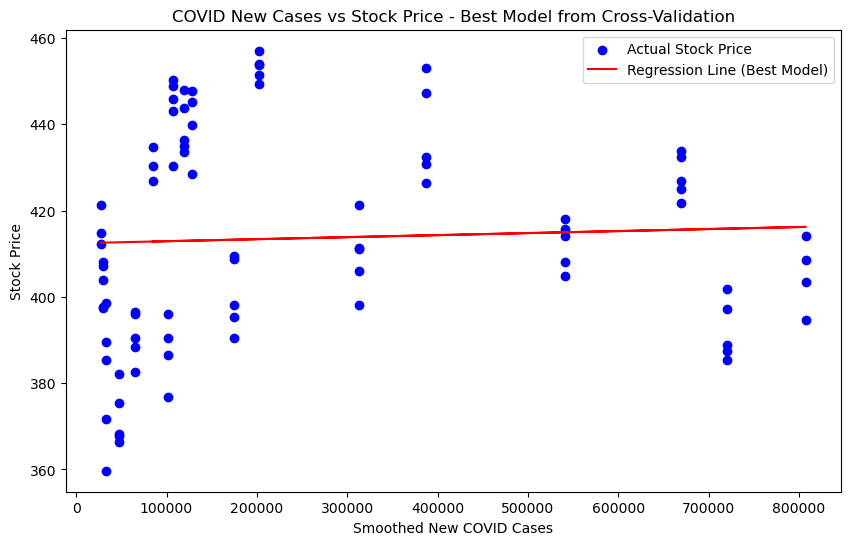


Regression Equation (Best Model):
Stock Price = 412.44 + 0.0000 * New COVID Cases


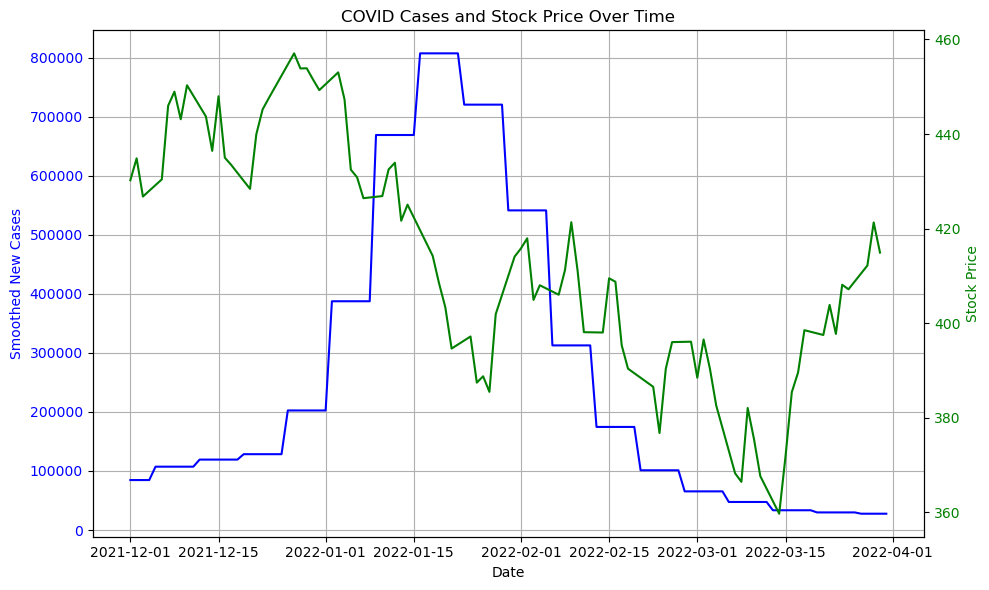

In [22]:
def predict_linear(covid_data, stock_data, target_column='Close', threshold=0.01, n_splits=20):
    # Select only date and new_cases_smoothed from COVID data
    covid_data = covid_data[['date', 'new_cases_smoothed']]

    # Ensure consistent date formatting
    covid_data = covid_data.copy() # pd. hates when values are altered in splices, so a copy is made
    covid_data['date'] = pd.to_datetime(covid_data['date']).dt.date
    
    # Remove timestamps from stock data Date column
    stock_data['Date'] = pd.to_datetime(stock_data['Date'], utc=True).dt.date

    # Inner join on date columns
    merged_data = pd.merge(covid_data, stock_data, left_on='date', right_on='Date', how='inner')

    # Prepare the data
    X = merged_data['new_cases_smoothed'].values.reshape(-1, 1)
    y = merged_data[target_column].values

    # Initialize KFold for cross-validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42) # As 42 is the answer to everything.. can be any number!

    # Create the model
    model = LinearRegression()

    # Cross-validation scores
    mse_scores = []
    r2_scores = []
    accuracy_scores = []

    # Initialize variables to track the best model
    best_model = None
    best_mse = float('inf')
    best_r2 = -float('inf')
    best_accuracy = 0
    best_fold = None
    best_X_test = None
    best_y_test = None
    best_y_pred = None

    # Loop over each fold
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate MSE, R-squared, and accuracy
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Calculate accuracy-like metric based on a threshold
        error = np.abs(y_test - y_pred)  # Absolute error
        correct_predictions = np.sum(error <= threshold * y_test)  # Predictions within threshold
        accuracy = correct_predictions / len(y_test)  # Proportion of correct predictions

        # Append scores for each fold
        mse_scores.append(mse)
        r2_scores.append(r2)
        accuracy_scores.append(accuracy)

        # Track the best fold based on MSE, R2, and accuracy (whichever is more important)
        if r2 > best_r2:
            best_mse = mse
            best_r2 = r2
            best_accuracy = accuracy
            best_fold = fold
            best_model = model  # Save the best model

    # Average scores across all folds
    avg_mse = np.mean(mse_scores)
    avg_r2 = np.mean(r2_scores)
    avg_accuracy = np.mean(accuracy_scores)

    # Print the average model performance
    print(f"Cross-Validation Results (over {n_splits} folds):")
    print(f"Average Mean Squared Error: {avg_mse}")
    print(f"Average R-squared Score: {avg_r2}")
    print(f"Average Accuracy (within {threshold * 100}% error): {avg_accuracy * 100:.2f}%")

    # Print the performance of the best model (best fold)
    print(f"\nBest Model Performance (from Fold {best_fold + 1}):")
    print(f"Best Model MSE: {best_mse}")
    print(f"Best Model R-squared: {best_r2}")
    print(f"Best Model Accuracy (within {threshold * 100}% error): {best_accuracy * 100:.2f}%")

    # After cross-validation, use the best model to predict on the entire dataset
    print("\nUsing the best model to predict on the entire dataset...")
    y_pred_all = best_model.predict(X)

    # Visualize the results for the best model
    plt.figure(figsize=(10, 6))
    plt.scatter(X, y, color='blue', label='Actual Stock Price')
    plt.plot(X, y_pred_all, color='red', label='Regression Line (Best Model)')
    plt.title(f'COVID New Cases vs Stock Price - Best Model from Cross-Validation')
    plt.xlabel('Smoothed New COVID Cases')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

    # Print regression equation for the best model
    print(f"\nRegression Equation (Best Model):")
    print(f"Stock Price = {best_model.intercept_:.2f} + {best_model.coef_[0]:.4f} * New COVID Cases")

# Load COVID data
covid_data = pd.read_csv('COVID Data\\filtered_us_covid_data.csv')

# Prompt for stock ticker
ticker = input("Enter the stock ticker (e.g., AAPL): ").upper()

# Load stock historical data
try:
    stock_data = pd.read_csv(f'Stock Data\\{ticker}_historical_data.csv')
except FileNotFoundError:
    print(f"Error: Could not find {ticker}_historical_data.csv")
    exit()

# Ensure date columns are in the same format
covid_data['date'] = pd.to_datetime(covid_data['date'])
stock_data['Date'] = pd.to_datetime(stock_data['Date'], utc=True)

# Run the analysis
predict_linear(covid_data, stock_data)

# Comparison
plot_covid_and_stock(covid_data, stock_data) # May need to re-run the cell which contains this function

## Facet Wrap for the Linear Regression

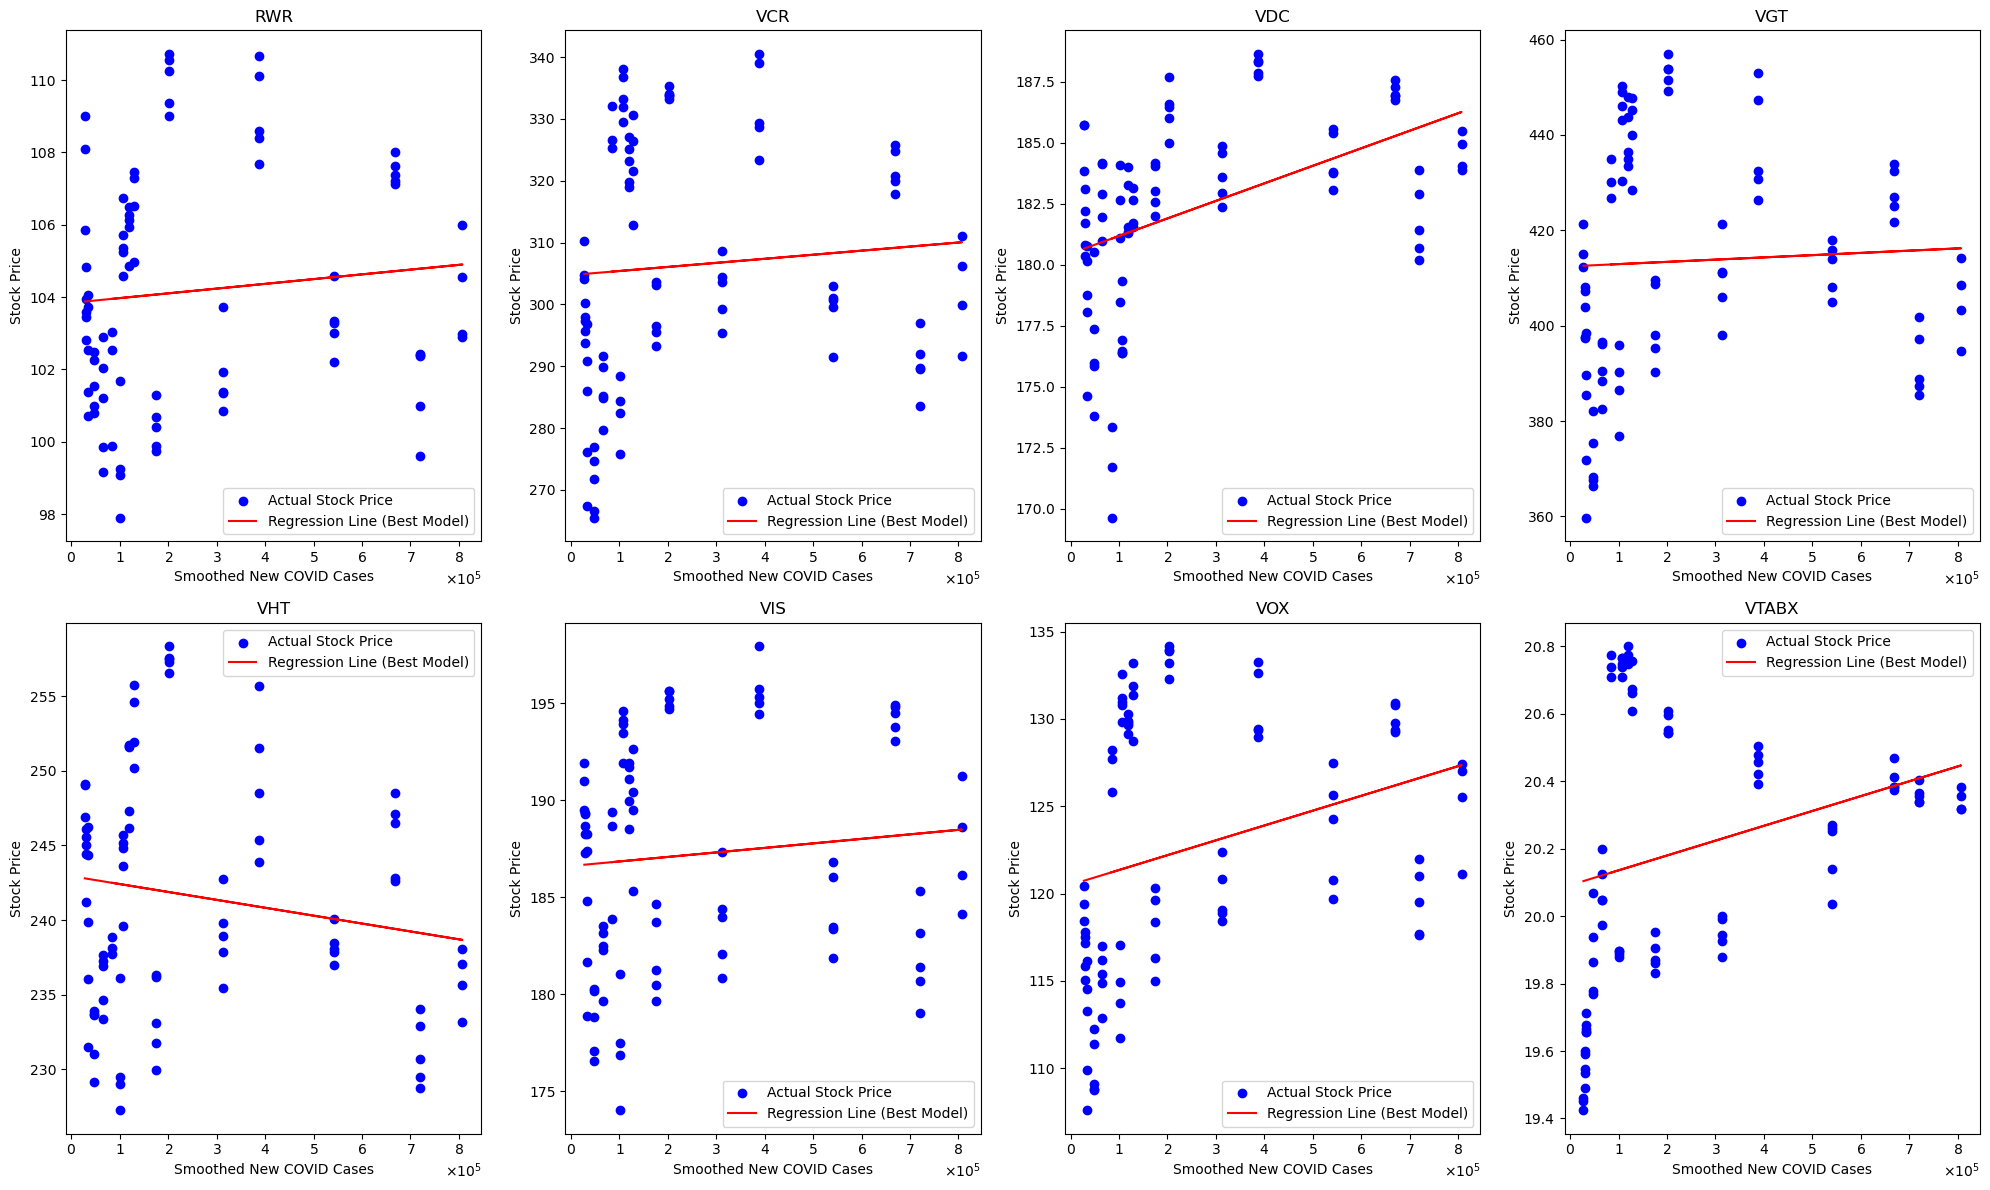

In [ ]:
def facet_linear(covid_data, stock_data, target_column='Close', threshold=0.01, n_splits=20):
    # Select only date and new_cases_smoothed from COVID data
    covid_data = covid_data[['date', 'new_cases_smoothed']]

    # Ensure consistent date formatting
    covid_data = covid_data.copy()  # pd. hates when values are altered in splices, so a copy is made
    covid_data['date'] = pd.to_datetime(covid_data['date']).dt.date
    
    # Remove timestamps from stock data Date column
    stock_data['Date'] = pd.to_datetime(stock_data['Date'], utc=True).dt.date

    # Inner join on date columns
    merged_data = pd.merge(covid_data, stock_data, left_on='date', right_on='Date', how='inner')

    # Prepare the data
    X = merged_data['new_cases_smoothed'].values.reshape(-1, 1)
    y = merged_data[target_column].values

    # Initialize KFold for cross-validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Create the model
    model = LinearRegression()

    # Cross-validation scores
    mse_scores = []
    r2_scores = []
    accuracy_scores = []

    # Initialize variables to track the best model
    best_model = None
    best_r2 = -float('inf')

    # Loop over each fold
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate MSE, R-squared, and accuracy
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Calculate accuracy-like metric based on a threshold
        error = np.abs(y_test - y_pred)  # Absolute error
        correct_predictions = np.sum(error <= threshold * y_test)  # Predictions within threshold
        accuracy = correct_predictions / len(y_test)  # Proportion of correct predictions

        # Append scores for each fold
        mse_scores.append(mse)
        r2_scores.append(r2)
        accuracy_scores.append(accuracy)

        # Track the best fold based on MSE, R2, and accuracy (whichever is more important)
        if r2 > best_r2:
            best_r2 = r2
            best_model = model  # Save the best model

    # After cross-validation, use the best model to predict on the entire dataset
    y_pred_all = best_model.predict(X)

    # Return the merged data, model, predictions, and the best model
    return X, y, y_pred_all


# Load COVID data
covid_data = pd.read_csv('COVID Data\\filtered_us_covid_data.csv')

# List of stock tickers
tickers = ['RWR', 'VCR', 'VDC', 'VGT', 'VHT', 'VIS', 'VOX', 'VTABX']

# Store the data for each plot
plot_data = []

# Generate and store the data for each ticker
for ticker in tickers:
    try:
        # Load stock historical data for the ticker
        stock_data = pd.read_csv(f'Stock Data\\{ticker}_historical_data.csv')

        # Call the prediction function and store the data
        X, y, y_pred_all = facet_linear(covid_data, stock_data)
        plot_data.append((ticker, X, y, y_pred_all))

    except FileNotFoundError:
        print(f"Error: Could not find {ticker}_historical_data.csv")
        continue

# Create a FacetGrid with the stored plots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 12))  # 2 rows, 4 columns for 8 tickers
axes = axes.flatten()  # Flatten the axes to easily loop through

# Loop through each stored plot data and plot in the appropriate axis
for i, (ticker, X, y, y_pred_all) in enumerate(plot_data):
    ax = axes[i]
    ax.scatter(X, y, color='blue', label='Actual Stock Price')
    ax.plot(X, y_pred_all, color='red', label='Regression Line (Best Model)')
    ax.set_title(f'{ticker}')
    ax.set_xlabel('Smoothed New COVID Cases')
    ax.set_ylabel('Stock Price')

    ax.legend()

    # Apply scientific notation to the x-axis for cleaner appearance
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    # Force scientific notation (this will apply the notation even for smaller values)
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


## Logistic Regression

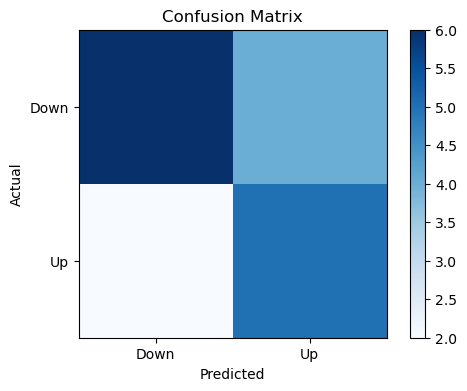

Model Performance:
Accuracy: 64.71%

Confusion Matrix:
[[6 4]
 [2 5]]


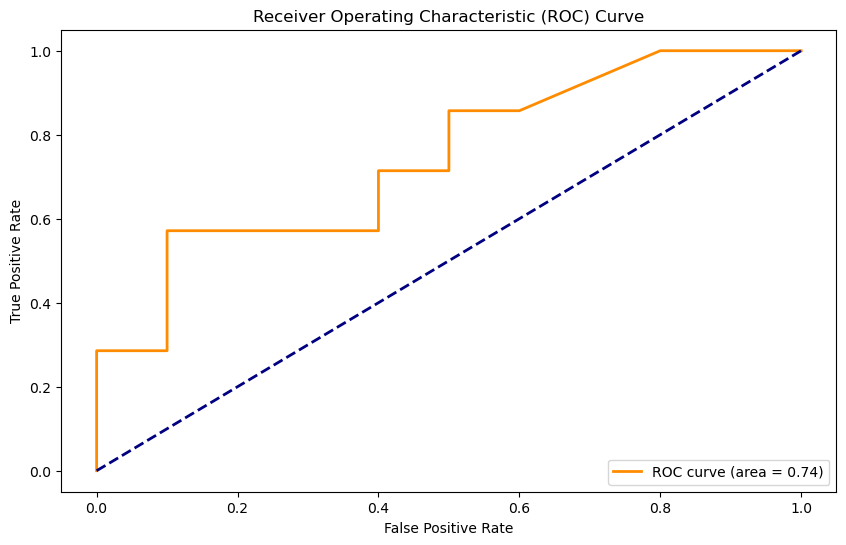


Logistic Regression Coefficients:
Intercept: 0.46, Coefficient: -0.0000


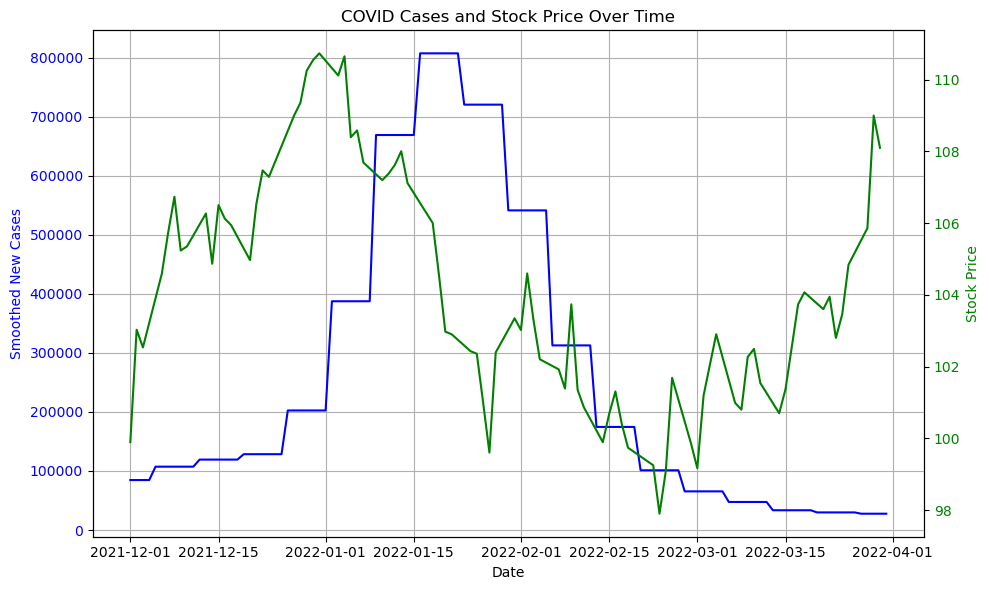

In [ ]:
def predict_logistic(covid_data, stock_data, target_column='Close'):
    # Select only date and new_cases_smoothed from COVID data
    covid_data = covid_data[['date', 'new_cases_smoothed']]

    # Ensure consistent date formatting
    covid_data = covid_data.copy() # pd. hates when values are altered in splices, so a copy is made
    covid_data['date'] = pd.to_datetime(covid_data['date']).dt.date

    # Remove timestamps from stock data Date column
    stock_data['Date'] = pd.to_datetime(stock_data['Date'], utc=True).dt.date

    # Inner join on date columns
    merged_data = pd.merge(covid_data, stock_data, left_on='date', right_on='Date', how='inner')

    # Prepare the data
    X = merged_data['new_cases_smoothed'].values.reshape(-1, 1)
    
    # Create a binary target: 1 if stock price went up, 0 if stock price went down
    y = np.where(merged_data[target_column].diff().shift(-1) > 0, 1, 0)  # 1 for up, 0 for down

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Similar sentiment as Linear Reg. (can be any number)

    # Create and train the logistic regression model
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Visualize the confusion matrix
    plt.figure(figsize=(6, 4))
    plt.imshow(cm, cmap='Blues', interpolation='nearest')
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks([0, 1], ['Down', 'Up'])
    plt.yticks([0, 1], ['Down', 'Up'])
    plt.show()

    # Print model performance metrics
    print("Model Performance:")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"\nConfusion Matrix:")
    print(cm)
    
    # Calculate ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

    # Compute the AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)

    # Visualize the ROC Curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random model
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Print model coefficients
    print(f"\nLogistic Regression Coefficients:")
    print(f"Intercept: {model.intercept_[0]:.2f}, Coefficient: {model.coef_[0][0]:.4f}")


# Load COVID data
covid_data = pd.read_csv('COVID Data\\filtered_us_covid_data.csv')

# Prompt for stock ticker
ticker = input("Enter the stock ticker (e.g., AAPL): ").upper()

# Load stock historical data
try:
    stock_data = pd.read_csv(f'Stock Data\\{ticker}_historical_data.csv')
except FileNotFoundError:
    print(f"Error: Could not find {ticker}_historical_data.csv")
    exit()

# Ensure date columns are in the same format
covid_data['date'] = pd.to_datetime(covid_data['date'])
stock_data['Date'] = pd.to_datetime(stock_data['Date'], utc=True)

# Run the analysis
predict_logistic(covid_data, stock_data)

# Comparison
plot_covid_and_stock(covid_data, stock_data)

## Facet Wrap for Logistic Regression 

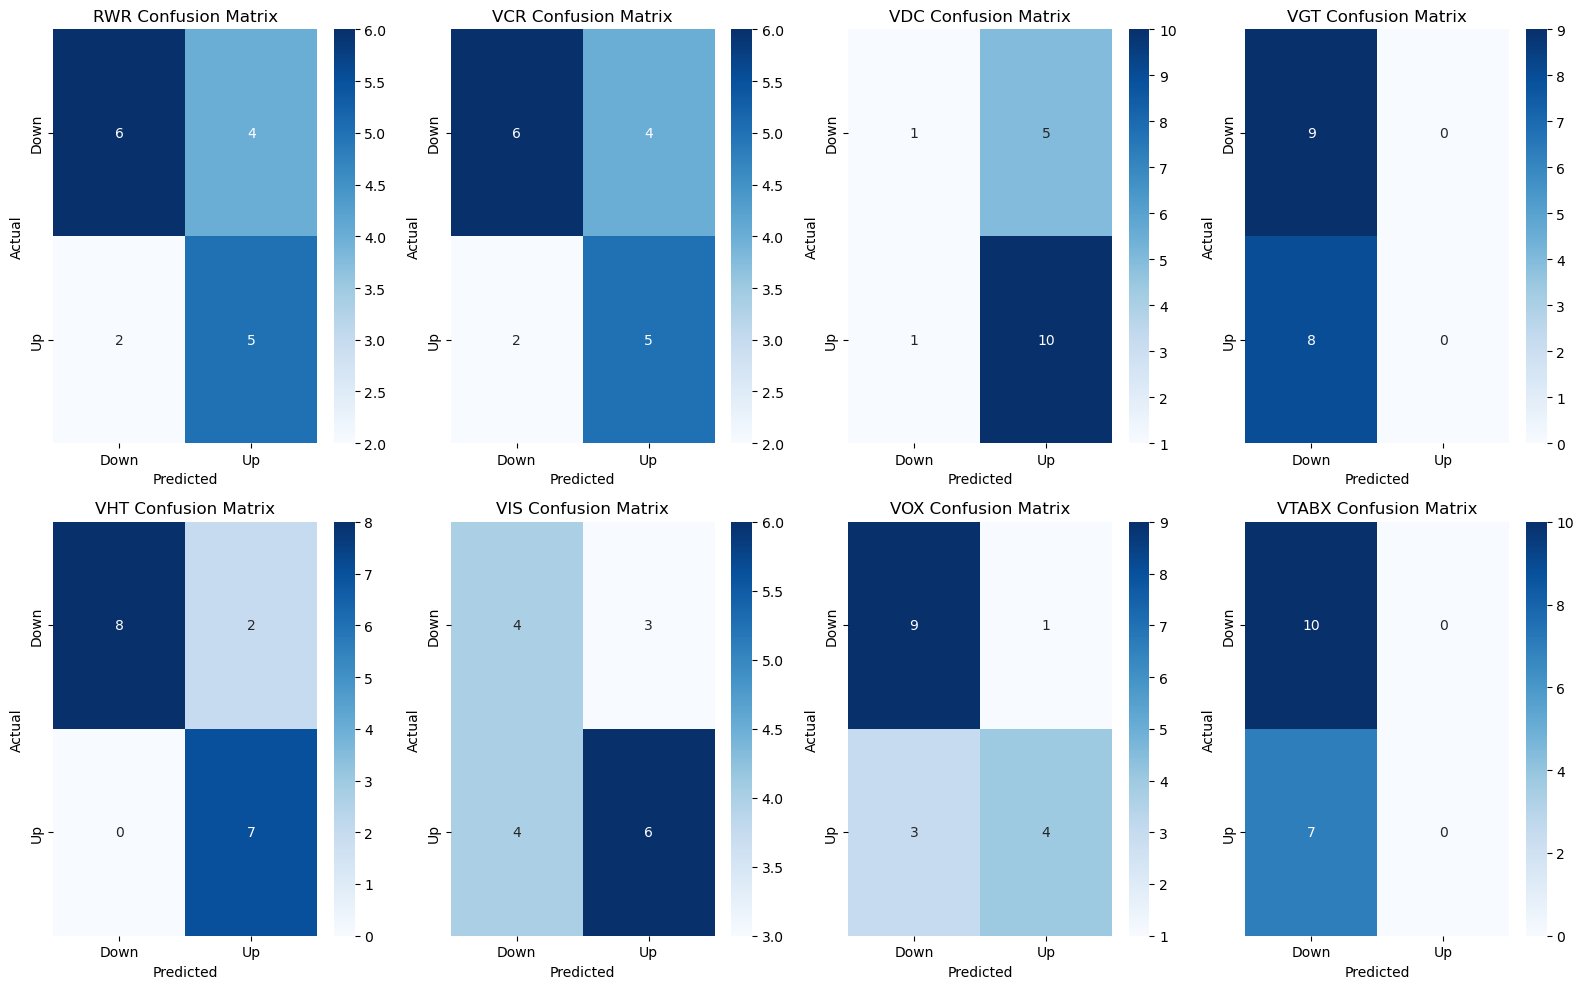

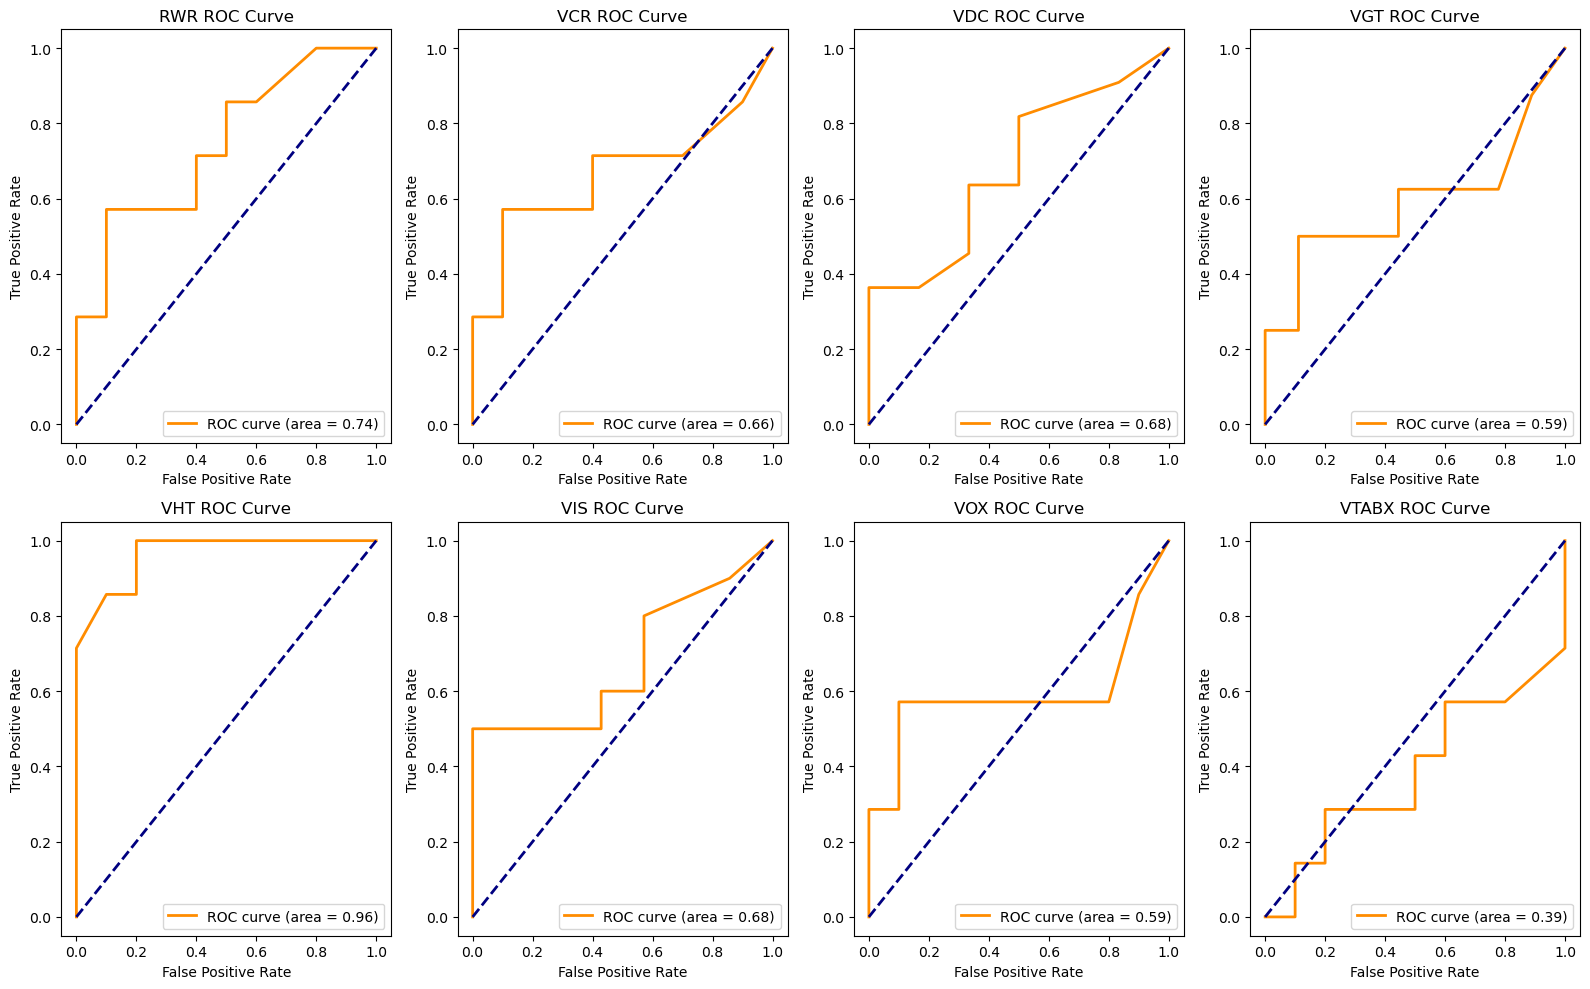

In [ ]:
# Function to return confusion matrix and ROC data
def facet_logistic(covid_data, stock_data, target_column='Close'):
    # Select only date and new_cases_smoothed from COVID data
    covid_data = covid_data[['date', 'new_cases_smoothed']]

    # Ensure consistent date formatting
    covid_data = covid_data.copy()
    covid_data['date'] = pd.to_datetime(covid_data['date']).dt.date

    # Remove timestamps from stock data Date column
    stock_data['Date'] = pd.to_datetime(stock_data['Date'], utc=True).dt.date

    # Inner join on date columns
    merged_data = pd.merge(covid_data, stock_data, left_on='date', right_on='Date', how='inner')

    # Prepare the data
    X = merged_data['new_cases_smoothed'].values.reshape(-1, 1)
    
    # Create a binary target: 1 if stock price went up, 0 if stock price went down
    y = np.where(merged_data[target_column].diff().shift(-1) > 0, 1, 0)  # 1 for up, 0 for down

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create and train the logistic regression model
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Calculate ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

    # Compute the AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)

    return cm, fpr, tpr, roc_auc


# Function to plot confusion matrix and ROC curve for multiple tickers
def plot_metrics_for_tickers(tickers, covid_data, target_column='Close'):
    # Create separate 2x4 grid figures for confusion matrix and ROC curves
    fig_cm, axs_cm = plt.subplots(2, 4, figsize=(16, 10))  # 2 rows, 4 columns for confusion matrix
    fig_roc, axs_roc = plt.subplots(2, 4, figsize=(16, 10))  # 2 rows, 4 columns for ROC curve

    # Flatten axes arrays for easier indexing
    axs_cm = axs_cm.flatten()
    axs_roc = axs_roc.flatten()

    for idx, ticker in enumerate(tickers):
        try:
            stock_data = pd.read_csv(f'Stock Data\\{ticker}_historical_data.csv')
        except FileNotFoundError:
            print(f"Error: Could not find {ticker}_historical_data.csv")
            continue
        
        # Run the logistic prediction model
        cm, fpr, tpr, roc_auc = facet_logistic(covid_data, stock_data, target_column)
        
        # Plot confusion matrix in the first figure
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'], ax=axs_cm[idx])
        axs_cm[idx].set_title(f'{ticker} Confusion Matrix')
        axs_cm[idx].set_xlabel('Predicted')
        axs_cm[idx].set_ylabel('Actual')

        # Plot ROC curve in the second figure
        axs_roc[idx].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        axs_roc[idx].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random model
        axs_roc[idx].set_xlabel('False Positive Rate')
        axs_roc[idx].set_ylabel('True Positive Rate')
        axs_roc[idx].set_title(f'{ticker} ROC Curve')
        axs_roc[idx].legend(loc='lower right')

    # Adjust layout for both figures
    fig_cm.tight_layout()
    fig_roc.tight_layout()

    # Show the plots
    plt.show()

# Load COVID data
covid_data = pd.read_csv('COVID Data\\filtered_us_covid_data.csv')

# List of stock tickers
tickers = ['RWR', 'VCR', 'VDC', 'VGT', 'VHT', 'VIS', 'VOX', 'VTABX']

# Plot confusion matrix and ROC curves for all tickers
plot_metrics_for_tickers(tickers, covid_data)


## SVM Exploratory Analysis

RWR - Real Estate: Non-Tech
VCR - Consumer Cyclical: Non-Tech
VDC - Consumer Defensive: Non-Tech
VGT - Technology: Tech
VHT - Healthcare: Non-Tech
VIS - Industrial: Tech
VOX - Communications: Tech
VTABX - World Bonds Hedged: Non-Tech

Accuracy: 48.12%
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.58      0.58        81
           1       0.33      0.33      0.33        52

    accuracy                           0.48       133
   macro avg       0.45      0.45      0.45       133
weighted avg       0.48      0.48      0.48       133



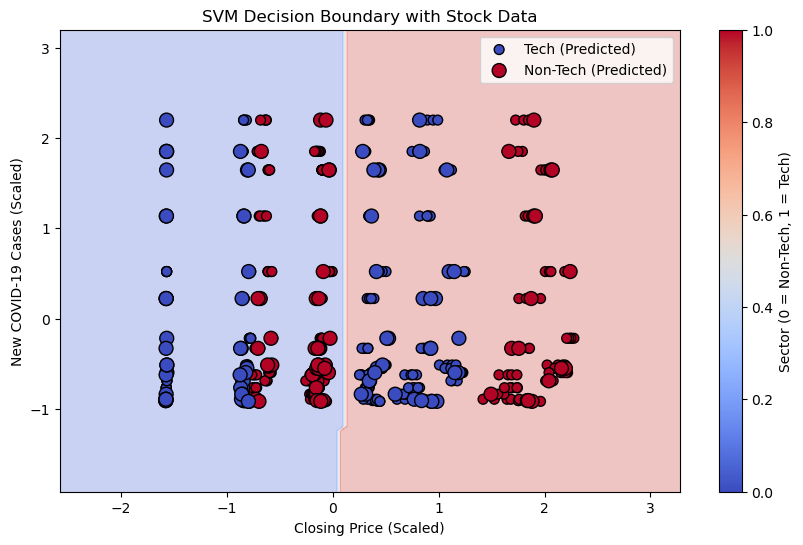

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Define the stock tickers and their sector categories 
# Binary Classification: 0 is Non-Tech and 1 is Tech
sector_dict = {
    'RWR': 0, 
    'VCR': 0,
    'VDC': 1,  
    'VGT': 1, 
    'VHT': 0,  
    'VIS': 1, 
    'VOX': 1, 
    'VTABX': 0  
}

# Function to load and prepare the stock data and merge with covid data
def prepare_data(ticker, covid_df):
    # Load the stock data for the ticker
    stock_file = f"Stock Data\\{ticker}_historical_data.csv"
    if not os.path.exists(stock_file):
        print(f"Stock data for {ticker} not found.")
        return None
    
    stock_df = pd.read_csv(stock_file)
    
    # Ensure consistent date formatting in stock data
    stock_df['Date'] = pd.to_datetime(stock_df['Date'], utc=True).dt.date
    
    # Select only date and new_cases_smoothed from COVID data
    covid_data = covid_df[['date', 'new_cases_smoothed']]
    
    # Ensure consistent date formatting in COVID data
    covid_data = covid_data.copy()  # pd. hates when values are altered in splices, so a copy is made
    covid_data['date'] = pd.to_datetime(covid_data['date']).dt.date
    
    # Merge stock data with COVID data on 'Date'
    merged_df = pd.merge(stock_df, covid_data, left_on='Date', right_on='date', how='left')
    
    return merged_df

# Load the COVID data (filtered_us_covid_data.csv)
covid_data = pd.read_csv('COVID Data\\filtered_us_covid_data.csv')

# Prepare an empty list to store the processed data for all tickers
all_data = []

# Loop over the tickers and prepare the data
for ticker in sector_dict.keys():
    merged_data = prepare_data(ticker, covid_data)
    if merged_data is not None:
        # Add a new column for the sector label
        merged_data['Sector'] = sector_dict[ticker]
        
        # Only keep relevant features: Closing price and New_Cases
        merged_data = merged_data[['Close', 'new_cases_smoothed', 'Sector']]
        
        # Drop rows with missing values (e.g., missing COVID data)
        merged_data.dropna(inplace=True)
        
        all_data.append(merged_data)

# Combine all the data into a single DataFrame
final_data = pd.concat(all_data)

# Features (X): Closing price and New COVID-19 cases
X = final_data[['Close', 'new_cases_smoothed']]

# Target (y): Sector (Tech or Non-Tech)
y = final_data['Sector']

# Split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the SVM classifier (using a linear kernel)
svm = SVC(kernel='linear')
svm.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = svm.predict(X_test_scaled)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=0)

# Output the results
print(f'Accuracy: {accuracy * 100:.2f}%')
print('Classification Report:')
print(report)

# Visualization of the SVM decision boundary and data points
plt.figure(figsize=(10, 6))

# Plot the decision boundary
xx, yy = np.meshgrid(np.linspace(X_train_scaled[:, 0].min() - 1, X_train_scaled[:, 0].max() + 1, 100),
                     np.linspace(X_train_scaled[:, 1].min() - 1, X_train_scaled[:, 1].max() + 1, 100))

Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')

# Plot data points
plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, cmap='coolwarm', s=50, edgecolors='k')
plt.scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], c=y_test, marker='o', cmap='coolwarm', s=100, edgecolors='k')

# Adding labels
plt.title("SVM Decision Boundary with Stock Data")
plt.xlabel("Closing Price (Scaled)")
plt.ylabel("New COVID-19 Cases (Scaled)")
plt.legend(["Tech (Predicted)", "Non-Tech (Predicted)", "Tech (Actual)", "Non-Tech (Actual)"], loc="best")
plt.colorbar(label="Sector (0 = Non-Tech, 1 = Tech)")

# Show plot
plt.show()
